# Introduction
Wide and deep architect has been proven as one of deep learning applications combining memorization and generatlization in areas such as search and recommendation. Google released its [wide&deep learning](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) in 2016. 

* wide part: helps to memorize the past behaviour for specific choice
* deep part: embed into low dimension, help to discover new user, product combinations

Later, on top of wide & deep learning, [deepfm](https://arxiv.org/abs/1703.04247) was developed combining DNN model and Factorization machines, to furthur address the interactions among the features. 

## wide & deep model
![wide&deep learning](https://1.bp.blogspot.com/-Dw1mB9am1l8/V3MgtOzp3uI/AAAAAAAABGs/mP-3nZQCjWwdk6qCa5WraSpK8A7rSPj3ACLcB/s640/image04.png)
## deepFM model
![deepfm learning](https://www.researchgate.net/profile/Huifeng_Guo/publication/318829508/figure/fig1/AS:522607722467328@1501610798143/Wide-deep-architecture-of-DeepFM-The-wide-and-deep-component-share-the-same-input-raw.png)

## Comparison
wide&deep learning is logistic regression + deep neural network. In wide part of wide & deep learning, it is a logistic regression, which requires a lot of manual feature engineering efforts to generate the large-scale feature set for wide part.    
While the deepfm model instead is factorization machines + deep neural network, as known as neural factorization machines. 
DeepFM has

* 1st order embeded layers to have overall characterization of indiviual features.
\begin{equation*}
y = \sum{w_ix_i}
\end{equation*}
* 2nd order shared embeded layers for both deep and fm parts, from which dot product between pairs of embeded features address the 2nd order feature interactions.
\begin{equation*}
y = \sum{w_{i,j}x_ix_j}
\end{equation*}
If the only the factorization machines part is kept, it will reduce to neural collabrative filtering. 

## DeepFM model in details
### 1st order factorization machines (summation of all 1st order embed layers)
+ numeric features with shape (None, 1) => dense layer => map to shape (None, 1)
+ categorical features (single level) with shape (None,1) => embedding layer (latent_dim = 1) => map to shape (None, 1)
+ categorical features (multi level) with shape (None,L) => embedding layer (latent_dim = 1) => map to shape (None, L)
+ output will summation of all embeded features, result in a tensor with shape (None, 1)
### 2nd order factorization machines (summation of dot product between 2nd order embed layers)
+ numeric features => dense layer => map to shape (None, 1, k)
+ categorical features (single level) => embedding layer (latent_dim = k) => map to shape (None, 1, k)
+ categorical features (multi level) with shape (None,L) => embedding layer (latent_dim = k) => map to shape (None, L, k)
+ shared embed layer will be the concatenated layers of all embeded features
+ shared embed layer => dot layer => 2nd order of fm part
### deep part (DNN model on shared embed layers)
+ shared embed layer => series of dense layers => deep part
    

## preprocess data

The dataset used to implement deepfm is movieLens(ml-1m) data.    
To add more features to the `ratings.dat`, I joined the user features and movies features.
The features used are as below:
* numeric feature: user_fea3
* categorical feature (single level): uid, mid
* categorical feature (multi level): movie_genre

movie genre is a mutli-value field delimited by `'|'`.   
Multi-Hot encoding of this field is done by kera text `Tokenizer`. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_ratings():
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv('./dataset/ml-1m/ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_movies():
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv('./dataset/ml-1m/movies.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_users():
    COL_NAME = ['uid','user_fea1','user_fea2','user_fea3','user_fea4']
    df = pd.read_csv('./dataset/ml-1m/users.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def text2seq(text, n_genre):
    """ using tokenizer to encoded the multi-level categorical feature
    """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_genre)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=3,padding='post')
    return seq

n_genre = 15

ratings = load_ratings()
movies = load_movies()
users = load_users()

print("====== rating.dat ======")
print(ratings.head())
print("===== movies.dat ======")
print(movies.head())
print("====== users.dat ======")
print(users.head())

movies['movie_genre'] = text2seq(movies.movie_genre.values, n_genre=n_genre).tolist()

ratings = ratings.join(movies.set_index('mid'), on = 'mid', how = 'left')
ratings = ratings.join(users.set_index('uid'), on = 'uid', how = 'left')
print("====== preprocessed data =======")
(ratings.head())

====== rating.dat ======
   uid   mid  rating  timestamp
0    1  1193       5  978300760
1    1   661       3  978302109
2    1   914       3  978301968
3    1  3408       4  978300275
4    1  2355       5  978824291
===== movies.dat ======
   mid                          movie_name                   movie_genre
0    1                    Toy Story (1995)   Animation|Children's|Comedy
1    2                      Jumanji (1995)  Adventure|Children's|Fantasy
2    3             Grumpier Old Men (1995)                Comedy|Romance
3    4            Waiting to Exhale (1995)                  Comedy|Drama
4    5  Father of the Bride Part II (1995)                        Comedy
====== users.dat ======
   uid user_fea1  user_fea2  user_fea3 user_fea4
0    1         F          1         10     48067
1    2         M         56         16     70072
2    3         M         25         15     55117
3    4         M         45          7     02460
4    5         M         25         20     55455
===

,uid,mid,rating,timestamp,movie_name,movie_genre,user_fea1,user_fea2,user_fea3,user_fea4
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]",F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),"[9, 13, 0]",F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),"[13, 5, 0]",F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),"[1, 0, 0]",F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)","[9, 2, 0]",F,1,10,48067


## Construct model

There are 3 parts of the deepFM models:

* 1st order factorization machines
* 2nd order factorization machines
* deep neural network

Let's start with input layer definition.

### define input layers

For dataset mixed with numeric and categerical features, they need to be treated differently.
* numeric features can be concatenated to inputs, with shape (None, num_of_numeric)
* categorical features can be encoded individually to inputs, with shape (None, 1) each.

In [2]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers():
    # numerica features
    fea3_input = Input((1,), name = 'input_fea3')
    num_inputs = [fea3_input]
    # single level categorical features
    uid_input = Input((1,), name = 'input_uid')
    mid_input = Input((1,), name= 'input_mid')
    cat_sl_inputs = [uid_input, mid_input]

    # multi level categorical features (with 3 genres at most)
    genre_input = Input((3,), name = 'input_genre')
    cat_ml_inputs = [genre_input]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    
    return inputs

inputs = define_input_layers()

### 1st order factorization machines

1st order will require features to map to a scalar.
so for
* numeric feature: a dense layer will convert tensor to shape (None,1)
* categorical feature: a embedding layer will convert tensor to shape (None,1,1) and then reshape layer to reshape to (None,1)

In [3]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_uid, n_mid, n_genre):
    
    fea3_input, uid_input, mid_input, genre_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_fea4')(fea3_input)]
    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid')(uid_input),
                        Embedding(n_mid + 1, 1, name = 'cat_embed_1d_mid')(mid_input)]
    cat_ml_embed_1d = [Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_genre')(genre_input)]

    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

y_1d = fm_1d(inputs, 10, 10, 10)

![title](./image/fm_model_1d.png)

### 2nd order factorization machines
In 2nd order FM, each feature is map to shape (None, 1, k) and then stack to `concat_embed_2d` layer with shape (None, p, k).    
k - matrix factorization latent dimension, p is feature dimension.

the calculation of interaction terms can be simplified, using    
\begin{equation*}
\sum{x_ix_j} = \frac{1}{2} \left((\sum{x})^2 - \sum({x}^2)\right)
\end{equation*}

Hence, the sum of 2nd order interactions = square of sum of `concat_embed_2d` - sum of squared `concat_embed_2d` in p dimension, the resulting tensor will have a shape (None, k)


In [4]:
def fm_2d(inputs, n_uid, n_mid, n_genre, k):
    
    fea3_input, uid_input, mid_input, genre_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_fea3')(fea3_input)] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)

    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid')(uid_input), 
                       Embedding(n_mid + 1, k, name = 'cat_embed_2d_mid')(mid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_genre + 1, k, name = 'cat_embed_2d_genre')(genre_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_genure_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

y_fm2_d, embed_2d = fm_2d(inputs, 10, 10, 10, 5)

![title](./image/fm_model_2d.png)

### deep part

this part is simply a DNN framework with input as `concat_embed_2d` layer

In [5]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = deep_part(embed_2d, [16, 16], 0.5)

![title](./image/deep_model.png)

### Put Together

In [6]:
def deep_fm_model(n_uid, n_mid, n_genre, k, dnn_dim, dnn_dr):
    
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_uid, n_mid, n_genre)
    y_fm_2d, embed_2d = fm_2d(inputs, n_uid, n_mid, n_genre, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name = 'deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

![title](./image/deep_fm_model.png)

In [7]:
params = {
    'n_uid': ratings.uid.max(),
    'n_mid': ratings.mid.max(),
    'n_genre': 14,
    'k':20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}

fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

## Split Data

In [8]:
def df2xy(ratings):
    x = [ratings.user_fea3.values, 
         ratings.uid.values, 
         ratings.mid.values, 
         np.concatenate(ratings.movie_genre.values).reshape(-1,3)]
    y = ratings.rating.values
    return x,y

in_train_flag = np.random.random(len(ratings)) <= 0.9
train_data = ratings.loc[in_train_flag,]
valid_data = ratings.loc[~in_train_flag,]
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

## Train Model

In [9]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
# train  model
deep_fm_model.compile(loss = 'MSE', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_ckp = ModelCheckpoint(filepath='./model/deepfm_weights.h5', 
                            monitor='val_loss',
                            save_weights_only=True, 
                            save_best_only=True)
callbacks = [model_ckp,early_stop]
train_history = deep_fm_model.fit(train_x, train_y, 
                                  epochs=30, batch_size=2048, 
                                  validation_split=0.1, 
                                  callbacks = callbacks)

/home/liuchr/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 810025 samples, validate on 90003 samples
Epoch 1/30
810025/810025 [==============================] - 8s 10us/step - loss: 2.3674 - val_loss: 3.6052
Epoch 2/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.9796 - val_loss: 2.8897
Epoch 3/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.9079 - val_loss: 2.4225
Epoch 4/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.8677 - val_loss: 2.1066
Epoch 5/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.8464 - val_loss: 1.8863
Epoch 6/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.8345 - val_loss: 1.7035
Epoch 7/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.8274 - val_loss: 1.6477
Epoch 8/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.8221 - val_loss: 1.5485
Epoch 9/30
810025/810025 [==============================] - 6s 8us/step - loss: 0.8179 - val_loss: 1

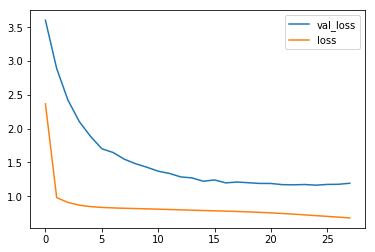

In [10]:
%matplotlib inline
pd.DataFrame(train_history.history).plot()

In [11]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))


contribution of different part of model
    weight of 1st order fm: -0.883
    weight of 2nd order fm: 1.518
    weight of dnn part: 0.469



## Model Architect

In [12]:
!rm -rf image
!mkdir image
from tensorflow.keras.utils import plot_model
plot_model(fm_model_1d, to_file='./image/fm_model_1d.png',show_shapes=True, show_layer_names=True)
plot_model(fm_model_2d, to_file='./image/fm_model_2d.png',show_shapes=True, show_layer_names=True)
plot_model(deep_model, to_file='./image/deep_model.png',show_shapes=True, show_layer_names=True)
plot_model(deep_fm_model, to_file='./image/deep_fm_model.png',show_shapes=True, show_layer_names=True)